<a href="https://colab.research.google.com/github/yara-esmaiel/Bitcoin-price-prediction/blob/main/Bitcoin_Price_Prediction(LSTM%2CLayers%3D2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAYERS =2 ,LSTM
PENALITY =9
WINDOW SIZE = 15, 30 , 60
TIME= 1-1-2015 TO 24-6-2022   

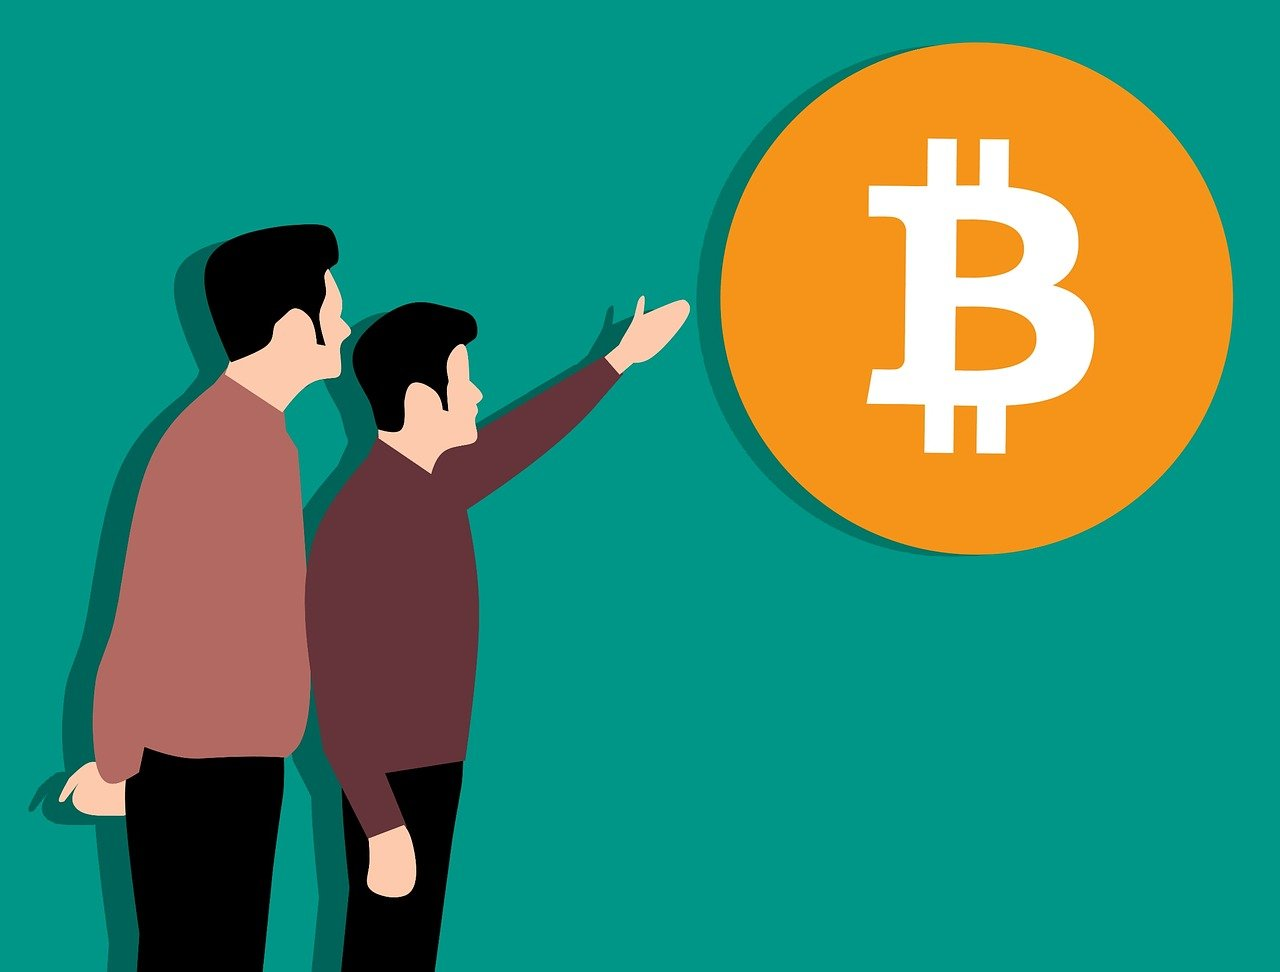

# Processing

In [ ]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:

from numpy.random import seed
seed(1)
from tensorflow import keras
SEED = 1
keras.utils.set_random_seed(SEED)

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [ ]:
# Load our dataset 
# Note it should be in same dir


maindf=pd.read_csv('/content/drive/MyDrive/BTC/BTC-USD from2014 to 24-6-2022.csv')

In [ ]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2022-06-24


In [ ]:
maindf.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
maindf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2838 non-null   object 
 1   Open       2838 non-null   float64
 2   High       2838 non-null   float64
 3   Low        2838 non-null   float64
 4   Close      2838 non-null   float64
 5   Adj Close  2838 non-null   float64
 6   Volume     2838 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.3+ KB


In [ ]:
maindf.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2.838000e+03
mean,12399.341018,12722.525499,12036.373224,12405.003057,12405.003057,1.539525e+10
std,16612.757792,17042.075739,16114.435061,16608.324661,16608.324661,1.995297e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,629.677506,639.339523,620.328247,630.604264,630.604264,8.595492e+07
50%,6532.800049,6635.975098,6447.389892,6532.510010,6532.510010,5.680985e+09
75%,11430.774658,11763.756836,11184.256103,11468.886963,11468.886963,2.628780e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [ ]:
#Checking for Null Values
print('Null Values:',maindf.isnull().values.sum())


Null Values: 0


In [ ]:
print('NA values:',maindf.isnull().values.any())


NA values: False


In [ ]:
maindf.shape


(2838, 7)

In [ ]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2838, 2)


In [ ]:
#Now we will Take data of just 1 Year

closedf = closedf[(closedf['Date'] > '2015-01-1') & (closedf['Date'] < '2022-06-15')]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2713


In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
realdf=closedf
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
print(closedf)

(2713, 1)
[[0.00143485]
 [0.00129928]
 [0.00133098]
 ...
 [0.39449545]
 [0.33105368]
 [0.32688985]]


In [ ]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
#print("train_data: ", train_data)
#print("test_data: ", test_data)


train_data:  (1627, 1)
test_data:  (1086, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# **window=15**

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1611, 15)
y_train:  (1611,)
X_test:  (1070, 15)
y_test (1070,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1611, 15, 1)
X_test:  (1070, 15, 1)


In [ ]:
y_test 

array([0.17775095, 0.16591142, 0.17269778, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout
# Actuall modelLSTM Building
modelLSTM=Sequential()

modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelLSTM.add(LSTM(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path_2_15 = 'my_best_model_2_15.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint15 = ModelCheckpoint(filepath=checkpoint_path_2_15, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint15, earlystopping]


In [ ]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
51/51 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0019
Epoch 1: val_mean_squared_error improved from inf to 0.12944, saving model to my_best_model_2_15.hdf5
51/51 [==============================] - 5s 45ms/step - loss: 0.0031 - mean_squared_error: 0.0019 - val_loss: 0.2589 - val_mean_squared_error: 0.1294
Epoch 2/300
51/51 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0026
Epoch 2: val_mean_squared_error did not improve from 0.12944
51/51 [==============================] - 2s 35ms/step - loss: 0.0039 - mean_squared_error: 0.0026 - val_loss: 0.2816 - val_mean_squared_error: 0.1408
Epoch 3/300
51/51 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0027
Epoch 3: val_mean_squared_error improved from 0.12944 to 0.11055, saving model to my_best_model_2_15.hdf5
51/51 [==============================] - 2s 36ms/step - loss: 0.0038 - mean_squared_error: 0.0027 - val_loss: 0.2211

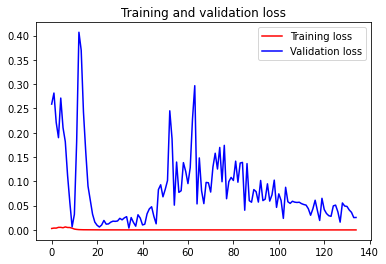

<Figure size 432x288 with 0 Axes>

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint_2_15 = load_model('/content/my_best_model_2_15.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint_2_15.predict(X_train)
test_predict=model_from_saved_checkpoint_2_15.predict(X_test)
train_predict.shape, test_predict.shape

((1611, 1), (1070, 1))

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

## `RESULT W=15`

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  695.3839172985413
Train data MSE:  483558.7924374646
Train data MAE:  449.07124357948527
-------------------------------------------------------------------------------------
Test data RMSE:  3112.2629943574457
Test data MSE:  9686180.946046773
Test data MAE:  2154.503079403563


In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9655284253521099
Test data explained variance regression score: 0.9807742512141902


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.964957596634957
Test data R2 score: 0.9719583373189273


In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.20136597256333408
Test data MGD:  0.01072215200844611
----------------------------------------------------------------------
Train data MPD:  160.47556745030516
Test data MPD:  278.4870129376508


## Custom Score 

In [ ]:
import numpy as np

def nana_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Nana error nigative : " + str(error_n))
    print("Nana error positive : " + str(error_p))
    print("Nana total_error : " + str(total_error))

In [ ]:
nana_score(original_ytrain, train_predict)

Nana error nigative : [-0.81230333]
Nana error positive : [0.1401913]
Nana total_error : [-0.67211203]


In [ ]:
nana_score(original_ytest, test_predict)

Nana error nigative : [-0.06054607]
Nana error positive : [0.07987642]
Nana total_error : [0.01933036]


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)




```
# This is formatted as code
```



In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)




```
# This is formatted as code
```



##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=15
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint_2_15.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint_2_15.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.4395539  0.4494726  0.43814878 0.44005597 0.44115034 0.46287519
 0.45968187 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545
 0.33105368 0.32688985 0.36704519]
1 day output [[0.35736093]]
2 day input [0.4494726  0.43814878 0.44005597 0.44115034 0.46287519 0.45968187
 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368
 0.32688985 0.36704519 0.35736093]
2 day output [[0.3491109]]
3 day input [0.43814878 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629
 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985
 0.36704519 0.35736093 0.3491109 ]
3 day output [[0.34152442]]
4 day input [0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.36704519
 0.35736093 0.3491109  0.34152442]
4 day output [[0.33441788]]
Output of predicted next days:  5


## Plotting last 15 days of dataset and next predicted 7 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[24912.810678994803, 24260.200429763237, 23704.24156765052, 23192.99840702769, 22714.097562003037]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=30**

In [ ]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1596, 30)
y_train:  (1596,)
X_test:  (1055, 30)
y_test (1055,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

In [ ]:
y_test 

array([0.14444165, 0.14382526, 0.13799897, ..., 0.41821102, 0.39449545,
       0.33105368])

## LOSS FUN

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K

from keras.layers import Dense, LSTM, Dropout
# Actuall modelLSTM Building
modelLSTM=Sequential()

modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelLSTM.add(LSTM(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path_2_30 = 'my_best_model_2_30.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint_2_30 = ModelCheckpoint(filepath=checkpoint_path_2_30, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint_2_30, earlystopping]


In [ ]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
50/50 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0020
Epoch 1: val_mean_squared_error improved from inf to 0.12958, saving model to my_best_model_2_30.hdf5
50/50 [==============================] - 7s 76ms/step - loss: 0.0031 - mean_squared_error: 0.0020 - val_loss: 0.2592 - val_mean_squared_error: 0.1296
Epoch 2/300
50/50 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0033
Epoch 2: val_mean_squared_error did not improve from 0.12958
50/50 [==============================] - 4s 70ms/step - loss: 0.0048 - mean_squared_error: 0.0033 - val_loss: 0.2956 - val_mean_squared_error: 0.1478
Epoch 3/300
50/50 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0031
Epoch 3: val_mean_squared_error improved from 0.12958 to 0.11449, saving model to my_best_model_2_30.hdf5
50/50 [==============================] - 3s 69ms/step - loss: 0.0051 - mean_squared_error: 0.0031 - val_loss: 0.2290

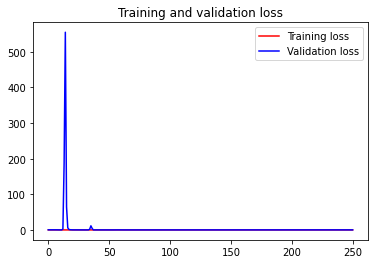

<Figure size 432x288 with 0 Axes>

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint30 = load_model('/content/my_best_model_2_30.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint30.predict(X_train)
test_predict=model_from_saved_checkpoint30.predict(X_test)
train_predict.shape, test_predict.shape

((1596, 1), (1055, 1))

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[29416.346]
 [29449.098]
 [29588.992]
 [31187.725]
 [31187.88 ]
 [30087.215]
 [29759.338]
 [28753.498]
 [27918.666]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=30`

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  721.8963200291013
Train data MSE:  521134.2968715586
Train data MAE:  617.4663689478383
-------------------------------------------------------------------------------------
Test data RMSE:  1497.2286543287548
Test data MSE:  2241693.6433430943
Test data MAE:  956.795687860219


In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9847027948514422
Test data explained variance regression score: 0.9935843811886422


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9623316501598459
Test data R2 score: 0.9935264682996507


In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.4811338239003589
Test data MGD:  0.002293379780687407
----------------------------------------------------------------------
Train data MPD:  422.01687159282767
Test data MPD:  58.08804360510191


## Custom Score 

In [ ]:
import numpy as np

def nana_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Nana error nigative : " + str(error_n))
    print("Nana error positive : " + str(error_p))
    print("Nana total_error : " + str(total_error))

In [ ]:
nana_score(original_ytrain, train_predict)

Nana error nigative : [-1.31875919]
Nana error positive : [0.04031981]
Nana total_error : [-1.27843938]


In [ ]:
nana_score(original_ytest, test_predict)

Nana error nigative : [-0.03657288]
Nana error positive : [0.03420665]
Nana total_error : [-0.00236623]


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)




```
# This is formatted as code
```



In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=30
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.31418094]
1 day output [[0.30266196]]
2 day input [0.42354516 0.4471999  0.43067497 0.43411006 0.44733922 0.42916389
 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381
 0.4681538  0.469132   0.4395539  0.4494726  0.43814878 0.44005597
 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738 0.42893973
 0.41821102 0.39449545 0.33105368 0.32688985 0.31418094 0.30266196]
2 day output [[0.29221588]]
3 day input [0.4471999  0.43067497 0.43411006 0.44733922 0.42916389 0.43742455
 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381 0.4681538
 0.469132   0.4395539  0.4494726  0.43814878 0.44005597 0.44115034
 0.46287519 0.45968187 0.44571629 0.

## Plotting last 30 days of dataset and next predicted 15 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[31 32 33 34 35]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[21350.356029373546, 20574.106313228785, 19870.158863840712, 19215.913825432737, 18599.750939804973]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=60**

In [ ]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1566, 60)
y_train:  (1566,)
X_test:  (1025, 60)
y_test (1025,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1566, 60, 1)
X_test:  (1025, 60, 1)


In [ ]:
y_test 

array([0.14812356, 0.14780536, 0.15125256, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout
# Actuall modelLSTM Building
modelLSTM=Sequential()

modelLSTM.add(LSTM(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelLSTM.add(LSTM(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelLSTM.add(Dense(1))


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path_2_60 = 'my_best_model_2_60.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelLSTM.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint_2_60 = ModelCheckpoint(filepath=checkpoint_path_2_60, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint_2_60, earlystopping]


In [ ]:
history = modelLSTM.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/49 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0018
Epoch 1: val_mean_squared_error improved from inf to 0.16212, saving model to my_best_model_2_60.hdf5
49/49 [==============================] - 9s 127ms/step - loss: 0.0031 - mean_squared_error: 0.0018 - val_loss: 0.3242 - val_mean_squared_error: 0.1621
Epoch 2/300
49/49 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0023
Epoch 2: val_mean_squared_error improved from 0.16212 to 0.09775, saving model to my_best_model_2_60.hdf5
49/49 [==============================] - 6s 118ms/step - loss: 0.0035 - mean_squared_error: 0.0023 - val_loss: 0.1955 - val_mean_squared_error: 0.0978
Epoch 3/300
49/49 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0039
Epoch 3: val_mean_squared_error improved from 0.09775 to 0.07076, saving model to my_best_model_2_60.hdf5
49/49 [==============================] - 6s 119ms/step - loss: 0.0061

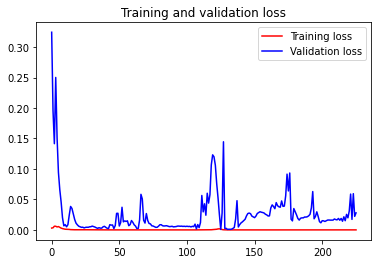

<Figure size 432x288 with 0 Axes>

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint_2_60 = load_model('/content/my_best_model_2_60.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint_2_60.predict(X_train)
test_predict=model_from_saved_checkpoint_2_60.predict(X_test)
train_predict.shape, test_predict.shape

((1566, 1), (1025, 1))

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[31039.342]
 [30779.527]
 [30633.305]
 [31220.63 ]
 [31555.47 ]
 [31337.533]
 [31100.191]
 [30472.842]
 [29730.014]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=60

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1600.2977621384857
Train data MSE:  2560952.927505445
Train data MAE:  1529.4748605960451
-------------------------------------------------------------------------------------
Test data RMSE:  1614.1124141036505
Test data MSE:  2605358.8853635145
Test data MAE:  1255.018195010823


In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9802806381185928
Test data explained variance regression score: 0.9935187442040058


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8158182600165095
Test data R2 score: 0.9925069406881509


In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.8690343572067928
Test data MGD:  0.006946403250501569
----------------------------------------------------------------------
Train data MPD:  1237.442276452066
Test data MPD:  101.03900353651841


## Custom Score 

In [ ]:
import numpy as np

def nana_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Nana error nigative : " + str(error_n))
    print("Nana error positive : " + str(error_p))
    print("Nana total_error : " + str(total_error))

In [ ]:
nana_score(original_ytrain, train_predict)

Nana error nigative : [-2.44593906]
Nana error positive : [0.04517987]
Nana total_error : [-2.40075919]


In [ ]:
nana_score(original_ytest, test_predict)

Nana error nigative : [-0.08213616]
Nana error positive : [0.03070094]
Nana total_error : [-0.05143522]


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=60
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint_2_60.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint_2_60.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.58672797 0.60318862 0.61322791 0.61132297 0.59875387 0.58707473
 0.58331164 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196
 0.57029898 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223
 0.54010575 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146
 0.42675169 0.42840474 0.43189718 0.44403812 0.46190235 0.44050121
 0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.36076394]
1 day output [[0.35636654]]
2 day input [0.60318862 0.61322791 0.61132297 0.59875387 0.58707473 0.58331164
 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196 0.57029898
 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223 0.54010575
 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146  0.42675169
 0.4284047

## Plotting last 60 days of dataset and next predicted 15 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
[61 62 63 64 65]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[40424.484375, 39716.953125, 40826.214844, 41502.75, 41374.378906, 40527.363281, 39740.320313, 39486.730469, 39469.292969, 40458.308594, 38117.460938, 39241.121094, 39773.828125, 38609.824219, 37714.875, 38469.09375, 38529.328125, 37750.453125, 39698.371094, 36575.140625, 36040.921875, 35501.953125, 34059.265625, 30296.953125, 31022.90625, 28936.355469, 29047.751953, 29283.103516, 30101.265625, 31305.113281, 29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[24489.52479941628, 24193.19014025451, 24094.43602062006, 24133.504268591445, 24264.34765291961]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
